# Explorative Datenanalyse
Im Folgenden werden die gemessenen Index-Werte der Brokkoli analysiert. Im Vorfeld wurden diese bereits innerhalb der Voronoi-Zellen segmentiert, das heisst Es werden nur noch die Pixel gewertet, welche zum Brokkoli gehören, ohne die Erde darum zu berücksichtigen.

In [127]:
# Datenabfrage von Server-DB
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# List of dates to be considered
dates = ['2019-04-18', '2019-04-25', '2019-05-01', '2019-05-09']

# Verbindungsaufbau
server = 'deepbroccoliserver.database.windows.net'
database = 'DeepBroccoliDatabase'
username = 'ntb'
password = 'brokkoli_2019'
driver= '{SQL Server}'
cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)

# Abfrage definieren und ausführen: Alle Brokkoli mit allen dazugehörigen Messwerten 
SQL_Query = pd.read_sql_query('''
select dbo.broccoli.id, dbo.broccolivalues.timestamp, dbo.broccoli.lat, dbo.broccoli.long, 
dbo.broccolivalues.pixelCount, dbo.broccolivalues.maxNDVI, dbo.broccolivalues.minNDVI,
dbo.broccolivalues.meanNDVI, dbo.broccolivalues.medianNDVI, dbo.broccolivalues.maxNDRE, dbo.broccolivalues.minNDRE,
dbo.broccolivalues.meanNDRE, dbo.broccolivalues.medianNDRE
from dbo.broccoli inner join dbo.broccolivalues on dbo.broccoli.id = dbo.broccolivalues.id''', cnxn)
broccoli_data = pd.DataFrame(SQL_Query)

# Describe: Erste Übersicht
#broccoli_data = broccoli_data.drop(broccoli_data.columns[3], axis=1)
broccoli_data.head()

,id,timestamp,lat,long,pixelCount,maxNDVI,minNDVI,meanNDVI,medianNDVI,maxNDRE,minNDRE,meanNDRE,medianNDRE
0,1,2019-04-18,47.217185,9.492887,3,0.417891,0.416200,0.416764,0.416200,0.098250,0.033404,0.055020,0.033404
1,1,2019-04-25,47.217185,9.492887,28,0.631827,0.399177,0.487436,0.470969,0.258980,-0.084967,0.120464,0.118629
2,1,2019-05-01,47.217185,9.492887,70,0.689316,0.400272,0.546891,0.556947,0.252909,0.015296,0.135502,0.135796
3,1,2019-05-09,47.217185,9.492887,269,0.788905,0.392496,0.520131,0.473748,0.177638,-0.060647,0.070062,0.066007
4,2,2019-04-18,47.217187,9.492902,20,0.536825,0.405282,0.467487,0.441985,0.219250,-0.017574,0.057152,0.047052


In [128]:
# Multiindex erstellen: ID + timestamp
broccoli_data.set_index(['id', 'timestamp'], drop=False, inplace=True)
#broccoli_data.drop(['id'], axis=1, inplace=True)
broccoli_data.head()

id  timestamp        lat      long  pixelCount   maxNDVI  \
id timestamp                                                              
1  2019-04-18   1 2019-04-18  47.217185  9.492887           3  0.417891   
   2019-04-25   1 2019-04-25  47.217185  9.492887          28  0.631827   
   2019-05-01   1 2019-05-01  47.217185  9.492887          70  0.689316   
   2019-05-09   1 2019-05-09  47.217185  9.492887         269  0.788905   
2  2019-04-18   2 2019-04-18  47.217187  9.492902          20  0.536825   

                minNDVI  meanNDVI  medianNDVI   maxNDRE   minNDRE  meanNDRE  \
id timestamp                                                                  
1  2019-04-18  0.416200  0.416764    0.416200  0.098250  0.033404  0.055020   
   2019-04-25  0.399177  0.487436    0.470969  0.258980 -0.084967  0.120464   
   2019-05-01  0.400272  0.546891    0.556947  0.252909  0.015296  0.135502   
   2019-05-09  0.392496  0.520131    0.473748  0.177638 -0.060647  0.070062   
2  2019-04-18  0.405282  0.467487    0.441985  0.219250 -0.017574  0.057152   

               medianNDRE  
id timestamp               
1  2019-04-18    0.033404  
   2019-04-25    0.118629  
   2019-05-01    0.135796  
   2019-05-09    0.066007  
2  2019-04-18    0.047052

## Analyse der Pixel-Menge (pixelCount)
Als erstes werden die Anzahl Pixel, die nach der Segmentierung eine Brokkoli-Pflanze darstellen, analysiert. Hier wird versucht, inkorrekt oders seltsam segmentierte Daten zu finden.

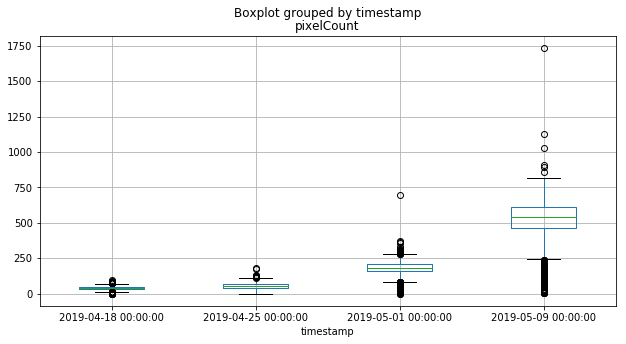

In [132]:
# Boxplot der Pixelanzahl gruppiert nach Datum
broccoli_data[broccoli_data.columns[2:]].boxplot(by="timestamp", column=['pixelCount'], figsize=(10,5))

In [133]:
# Ausgabe der Anzahl  Datenpunkte mit pixelCount in einem bestimmten Quantilsbereich

notablePixelCount_id = []
for date in dates:
    broccoli_data_byDate = broccoli_data[broccoli_data.timestamp == date]
    
    under25Quant = broccoli_data_byDate[broccoli_data_byDate.pixelCount < broccoli_data_byDate['pixelCount'].quantile(0.25)]
    under05Quant = broccoli_data_byDate[broccoli_data_byDate.pixelCount < broccoli_data_byDate['pixelCount'].quantile(0.05)]
    over75Quant = broccoli_data_byDate[broccoli_data_byDate.pixelCount > broccoli_data_byDate['pixelCount'].quantile(0.75)]
    over95Quant = broccoli_data_byDate[broccoli_data_byDate.pixelCount > broccoli_data_byDate['pixelCount'].quantile(0.95)]
    
    notablePixelCount_id.extend(under05Quant['id'])
    notablePixelCount_id.extend(over95Quant['id'])
    
    nofUnder25Quant = len(under25Quant)
    nofUnder05Quant = len(under05Quant)
    nofOver75Quant = len(over75Quant)
    nofOver95Quant = len(over95Quant)
    
    print(date + ":: <25%: " + str(nofUnder25Quant) + " | >75%; " + str(nofOver75Quant))
    print(date + ":: <05%: " + str(nofUnder05Quant) + " | >95%; " + str(nofOver95Quant))
    print()
    
notablePixelCount_id = list(dict.fromkeys(notablePixelCount_id))
np.savetxt("notablePixelCount_IDs.csv", notablePixelCount_id, delimiter=",")

2019-04-18:: <25%: 612 | >75%; 642
2019-04-18:: <05%: 129 | >95%; 123

2019-04-25:: <25%: 629 | >75%; 632
2019-04-25:: <05%: 131 | >95%; 130

2019-05-01:: <25%: 658 | >75%; 659
2019-05-01:: <05%: 134 | >95%; 133

2019-05-09:: <25%: 667 | >75%; 669
2019-05-09:: <05%: 134 | >95%; 134



array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002F1D3DA3860>,
      dtype=object)

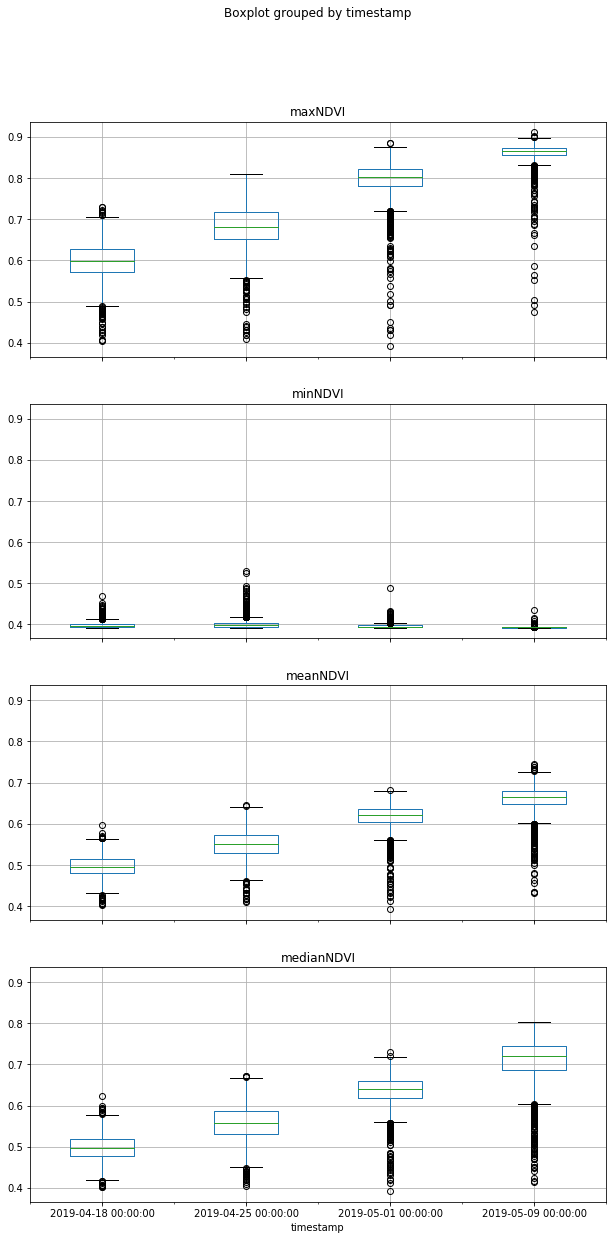

In [106]:
# Boxplot der NDVI-Werte gruppiert nach Datum
columns = ['maxNDVI', 'minNDVI', 'meanNDVI', 'medianNDVI']
broccoli_data[broccoli_data.columns[1:]].boxplot(by="timestamp", column=columns, layout=(len(dates), 1), 
                                                 figsize=(10,len(dates)*5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002F1D59AC940>,
      dtype=object)

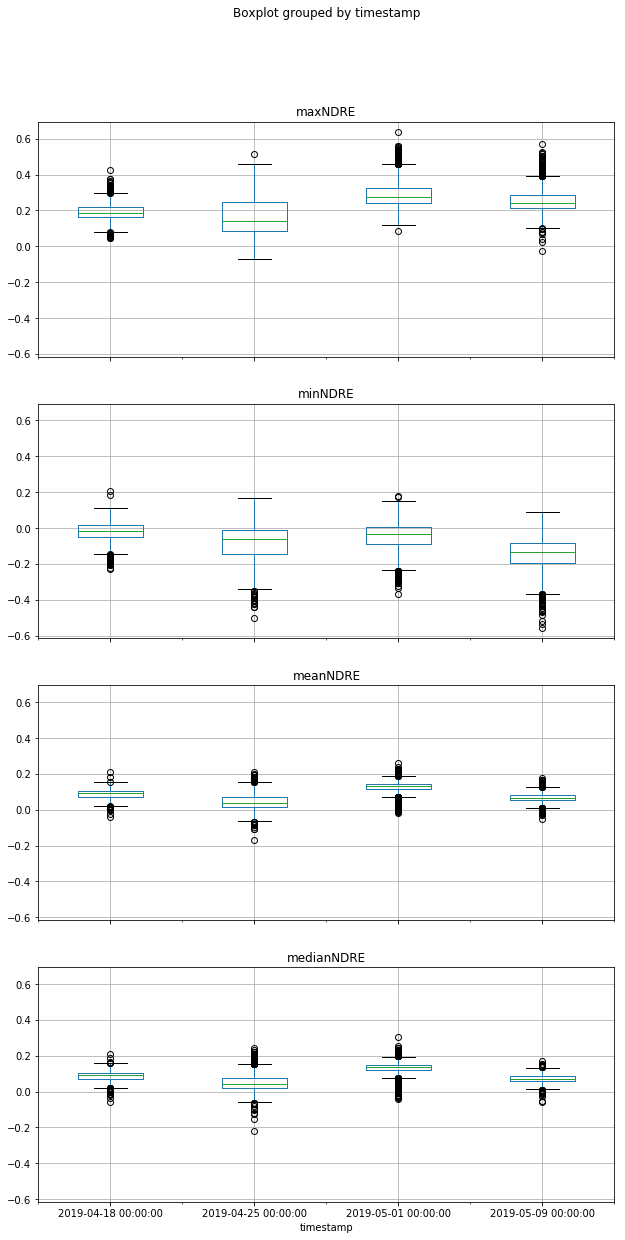

In [107]:
# Boxplot der NDRE-Werte gruppiert nach Datum
columns = ['maxNDRE', 'minNDRE', 'meanNDRE', 'medianNDRE']
broccoli_data[broccoli_data.columns[1:]].boxplot(by="timestamp", column=columns, layout=(len(dates), 1), 
                                                 figsize=(10,len(dates)*5))

In [41]:
# Daten mit nur einem Pixel analysieren
broccoli_data_1_pix = broccoli_data_1[broccoli_data.pixelCount <= 10]
broccoli_data_1_pix['id']

m:\stuff\sem6\bachelorarbeit\dataanalysis\dataanalysis\dataanalysisvirtualenv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


334       84
2563     643
3523     883
3662     918
3704     929
4275    1072
6820    1710
7024    1761
7092    1778
7183    1801
8099    2030
8238    2065
9632    2414
9940    2491
Name: id, dtype: int64